# Importing necessary modules

In [1]:
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt 
from itertools import combinations
from collections import Counter

# Loading and processing data

The following data was taken from: http://archive.ics.uci.edu/ml/datasets/Online+Retail

Attribute Information:

InvoiceNo: Invoice number. Nominal, a 6-digit integral number uniquely assigned to each transaction. 
           If this code starts with letter 'c', it indicates a cancellation.
StockCode: Product (item) code. Nominal, a 5-digit integral number uniquely assigned to each distinct product.
Description: Product (item) name. Nominal.
Quantity: The quantities of each product (item) per transaction. Numeric.
InvoiceDate: Invice Date and time. Numeric, the day and time when each transaction was generated.
UnitPrice: Unit price. Numeric, Product price per unit in sterling.
CustomerID: Customer number. Nominal, a 5-digit integral number uniquely assigned to each customer.
Country: Country name. Nominal, the name of the country where each customer reside



In [19]:
data = pd.read_excel('Online Retail.xlsx')

In [20]:
print(data.shape)
data.head()

(541909, 8)


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In this initial stage, we will look for data types of each column, as well as various values of the objects in order to better segment our data. 

In [21]:
data.dtypes

InvoiceNo              object
StockCode              object
Description            object
Quantity                int64
InvoiceDate    datetime64[ns]
UnitPrice             float64
CustomerID            float64
Country                object
dtype: object

In [22]:
# We find number of unique values in each column.
# Further, we find NAN values and their percentage for each column (we deal with this with a simple function)

columns = data.columns

print(pd.Series([len(data[col].unique()) for col in columns], [col for col in columns]))

def missing_data(data_frame):
    columns = data_frame.columns
    total_nan = data_frame.isnull().sum().sort_values(ascending = False)
    percentage_nan= (data_frame.isnull().sum()/data_frame.isnull().count()).sort_values(ascending = False)
    missing_d = pd.concat([total_nan, percentage_nan], axis = 1, keys=['Total', 'Percentage'])
    return print(missing_d)

missing_data(data)

InvoiceNo      25900
StockCode       4070
Description     4224
Quantity         722
InvoiceDate    23260
UnitPrice       1630
CustomerID      4373
Country           38
dtype: int64
              Total  Percentage
CustomerID   135080    0.249267
Description    1454    0.002683
Country           0    0.000000
UnitPrice         0    0.000000
InvoiceDate       0    0.000000
Quantity          0    0.000000
StockCode         0    0.000000
InvoiceNo         0    0.000000


Here are some initial thoughts and tasks: 

1) We see that InvoiceNo is an object type, which is probably due to the present of c in some of the data (see Attribute information). We will extract information about the cancelation. 

2) It will be interesting to know the monthly, yearly, daily and hourly habits of customers, so these columns will be added 
(for EDA later on).

3) The total amount spent per object (quantity*price) will also be intersting to know, so we will add a column to address this.

4) We see the high presence of NAN values in CustomerID as well as a small amount in Description. 

5) A potential problem comes from the relation between StockCode and Description. Ideally, there should be a one-on-one 
correspondence between the two, but, as we will see later, this is not the case (the same object appears with different 
descriptions). 

### 1) Adding cancelation column

In [23]:
# 1) Adding cancelation column

# We define function extracting c from the Invoice column

def can(string):
    if str(string).lower()[0] == 'c': # it could happen that the string starts with 'C' or 'c'
        return 1
    else:
        return 0
data['Canceled']=data['InvoiceNo'].apply(lambda x: can(x))

total_canceled = data['Canceled'].sum()/len(data['Canceled'])
print('Proportion of canceled elements: {:.3f}'.format(total_canceled))

Proportion of canceled elements: 0.017


### 2) Adding year, month and day columns

In [24]:
# Note that the InvoiceDate had no missing values, so we can do this

data[['Year', 'Month', 'Day', 'Hour']]=pd.concat([data['InvoiceDate'].dt.year, data['InvoiceDate'].dt.month, 
                                                     data['InvoiceDate'].dt.day, data['InvoiceDate'].dt.hour], axis =1,
                                                keys = ['Year', 'Month', 'Date', 'Hour'])
data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Canceled,Year,Month,Day,Hour
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,0,2010,12,1,8
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,0,2010,12,1,8
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,0,2010,12,1,8
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,0,2010,12,1,8
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,0,2010,12,1,8


### 3) Adding TotalSpent column

We calculate total_spent as quantity times unit_price. Once again, we note that there were no missing values in these 
columns, so we can do the following

In [25]:
data['TotalSpent']=data['Quantity']*data['UnitPrice']
data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Canceled,Year,Month,Day,Hour,TotalSpent
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,0,2010,12,1,8,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,0,2010,12,1,8,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,0,2010,12,1,8,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,0,2010,12,1,8,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,0,2010,12,1,8,20.34


### 4) Dealing with missing values

The columns of interest here are Description and CustomerID, since they are the only ones having NaN values. However, 
since we now have TotalSpent column, we may start there and look for the data where
TotalSpent =0 as these do not affect the analysis we will perform (at the same time, we will drop all the instances in
UnitPrice column which were zero)

In [26]:
# print(data[data['TotalSpent']==0].shape) # Size of data we are about to drop
data.drop(data[data['TotalSpent']==0].index, inplace=True)

# Checking the remaining missing data
missing_data(data) # As we see below, NaN values are only present in CustomerID 

              Total  Percentage
CustomerID   132605    0.245841
TotalSpent        0    0.000000
Hour              0    0.000000
Day               0    0.000000
Month             0    0.000000
Year              0    0.000000
Canceled          0    0.000000
Country           0    0.000000
UnitPrice         0    0.000000
InvoiceDate       0    0.000000
Quantity          0    0.000000
Description       0    0.000000
StockCode         0    0.000000
InvoiceNo         0    0.000000


One possible reason why the CustomerID is missing is that these customers are not registered in the retail shop. 
Since their number is not negligible, one way to deal with them is to assign them a provisional ID (for example the 
corresponding InvoiceNo). However, this affects the average number of InvoiceNo (purchases) per CustomerID as we see below:

In [27]:

l1 = len(data[~data['CustomerID'].isnull()]['CustomerID'].unique())
l2 = len(data[~data['CustomerID'].isnull()]['InvoiceNo'].unique()) 
l3 = len(data[data['CustomerID'].isnull()])
print(l1/l2)

0.19701613630217255


The number above means that a customer makes on average 5 purchases. If we were to asign a provisional Customer ID instead of NaN, this number would increase to 
(l1+l3)/(l2+l3) = 0.88 which means that customer makes a bit over 1 purchase in average.

This being said, we will proceed by creating a copy of our data where missing CutomerID's are removed.

In [28]:
new_data = data.drop(data[data['CustomerID'].isnull()].index)
new_data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Canceled,Year,Month,Day,Hour,TotalSpent
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,0,2010,12,1,8,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,0,2010,12,1,8,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,0,2010,12,1,8,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,0,2010,12,1,8,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,0,2010,12,1,8,20.34


### 5) Uniqueness of object Description

In [29]:
print(len(new_data['StockCode'].unique()), len(new_data['Description'].unique()))

3684 3896


As we see from above, there are more descriptions than objects, which means that some objects have different 
descriptions in different places. To deal with this, we create new dataset, data1, which contains only 
StockCode and Descrription columns, but now where in the Description column we cumulate all the possible descriptions 
of the object in form of a list.

In [30]:
data1 = pd.DataFrame(new_data.groupby('StockCode')['Description'].unique().apply(list))
data1.reset_index(inplace = True)

In [31]:
# These are objectst with at least two different descriptions:
data1[data1['Description'].map(len)>=2].head()

,StockCode,Description
48,20622,"[VIPPASSPORT COVER , VIP PASSPORT COVER ]"
100,20725,"[LUNCH BAG RED RETROSPOT, LUNCH BAG RED SPOTTY]"
192,20914,"[SET/5 RED RETROSPOT LID GLASS BOWLS, SET/5 RE..."
287,21109,"[LARGE CAKE TOWEL, CHOCOLATE SPOTS, LARGE CAKE..."
290,21112,"[SWISS ROLL TOWEL, PINK SPOTS, SWISS ROLL TOW..."


In [32]:
print(data1[data1['Description'].map(len)==4], data1[data1['Description'].map(len)==5])

     StockCode                                        Description
1960     23196  [RETRO LEAVES MAGNETIC NOTEPAD, RETO LEAVES MA...
2000     23236  [DOILEY STORAGE TIN, DOILEY BISCUIT TIN, STORA... Empty DataFrame
Columns: [StockCode, Description]
Index: []


From above we see that there are objects with even 4 different descriptions (and 4 is maximum). We also see that the 
difference in descriptions comes from different word ordering or typos. We will now modify our data to achieve uniqueness
in descriptions.


In [33]:
# We create a dictionary which keeps in place StockCode and all Descriptions of an object. Then, to each object we will 
# assign a the first element of the corresponding key_value.

keys_list = [key for key in data1['StockCode']]
keys_values = [value[0] for value in data1['Description']]
zip_list = zip(keys_list, keys_values)
change_dict = dict(zip_list)

In [34]:
# We create a new column, DescrUnique with unique description. It is much faster than if we were to change directly values
# of the Description column (whatever method we use, although it seems that using map is fastest). 

new_data['DescrUnique'] = data2['StockCode'].map(change_dict)

NameError: name 'data2' is not defined

In [ ]:
# To make sure that everything is working fine:

new_data.head()

In [ ]:
# Finally, we drop the old Description column and rearange things as they used to be:
new_data.drop('Description', axis = 1, inplace = True)
cols = new_data.columns.tolist()
cols = cols[:2]+[cols[-1]]+cols[2:-1]
new_data=new_data[cols]
new_data.rename(columns={'DescrUnique':'Description'}, inplace = True)
new_data.head()

We note that it could happen (and in our case it does), that several descriptions correspond to the same object. However 
that is to be expected.

### Dropping duplicates and saving new data

In [ ]:
new_data.drop_duplicates(inplace = True)
new_data.to_csv('data_clean.csv')

# or, for excel
# new_data.to_excel('data_clean.xlsx', engine='xlsxwriter') # engine='xlsxwriter' seems to speed up things

# EDA

In this section we perform some elementary analysis on our data. More precisely, the tasks that we will be doing are:
    
    1) Looking for outliers (in quantity and price columns)
    2) Trends of the global data, such as:
        * Total spent and activity per country
        * Monthly total spent and activity per country
        * Hourly cusomer behavior
    3) Local considertions such as:
        * Best customers in term of value spent and number of items purchased
        * Most popular items 
        * Couples of items most commonly bought together
        * A recommendation system for customers based on the results of previous task

## Outliers

In [ ]:
data = pd.read_csv('data_clean.csv', index_col = 0)
data.describe()

We notice that there are outliers for the Quantity and UnitPrice columns, so we take a closer look on these.

In [ ]:
data[data['Quantity']>1000].describe()

In [ ]:
data[data['Quantity']>1000]

We see that these are usually small, cheap items (max price is 5.06), so it is reasonable for them to be ordered in large quantities.  

On the other side:

In [ ]:
print('Stock codes of expensive items: ', data[data['UnitPrice']>500]['StockCode'].unique())
data[data['UnitPrice']>500].sort_values('UnitPrice',ascending = False)


Aparently, these are mostly items with StockCode not as in the attributes description. At first glance we also notice that
they are frequently canceled. 

## General considerations

### Total spent and Number of purchases per country

In [ ]:
# We next show the highest spenders and most frequent buyers by country.

print('Total amount spent by country (from highest to lowest:)\n', 
      data.groupby('Country').sum()['TotalSpent'].sort_values(ascending = False))

In [35]:
print('Total number of purchases per country (from highest to lowest:) \n', data.groupby('Country').count()['TotalSpent'].sort_values(ascending = False))

Total number of purchases per country (from highest to lowest:) 
 Country
United Kingdom          492981
Germany                   9493
France                    8556
EIRE                      8192
Spain                     2532
Netherlands               2367
Belgium                   2069
Switzerland               2001
Portugal                  1519
Australia                 1256
Norway                    1085
Italy                      803
Channel Islands            758
Finland                    695
Cyprus                     622
Sweden                     462
Unspecified                446
Austria                    401
Denmark                    389
Japan                      358
Poland                     341
Israel                     297
USA                        291
Hong Kong                  288
Singapore                  229
Iceland                    182
Canada                     151
Greece                     146
Malta                      127
United Arab Emirates       

We see that United Kingdom dominates by at least an order of magnitude, so we will not represent it in the following 
charts

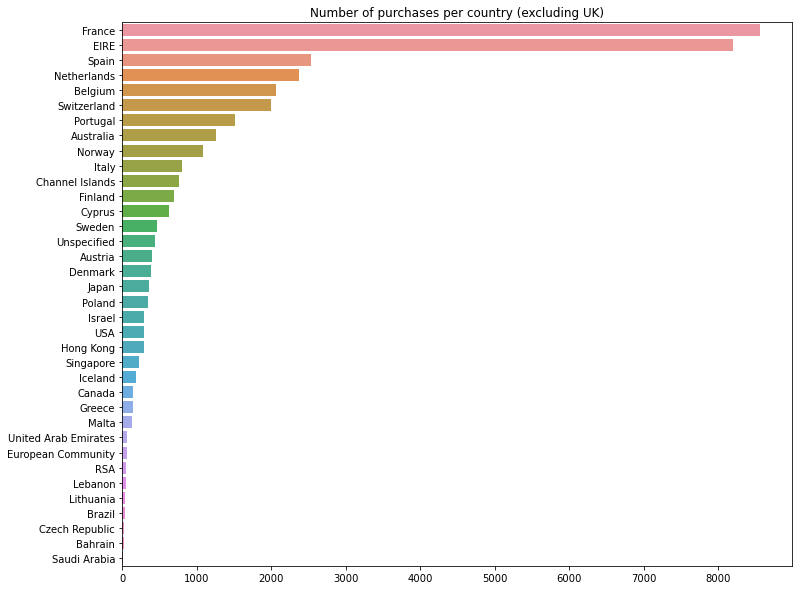

In [36]:
# Total number of purchases (excluding UK)

plt.rcParams['figure.figsize']=(12,10)
a = data['Country'].value_counts().tail(36)
sn.barplot(x = a.values, y=a.index).set_title('Number of purchases per country (excluding UK)')
plt.show()

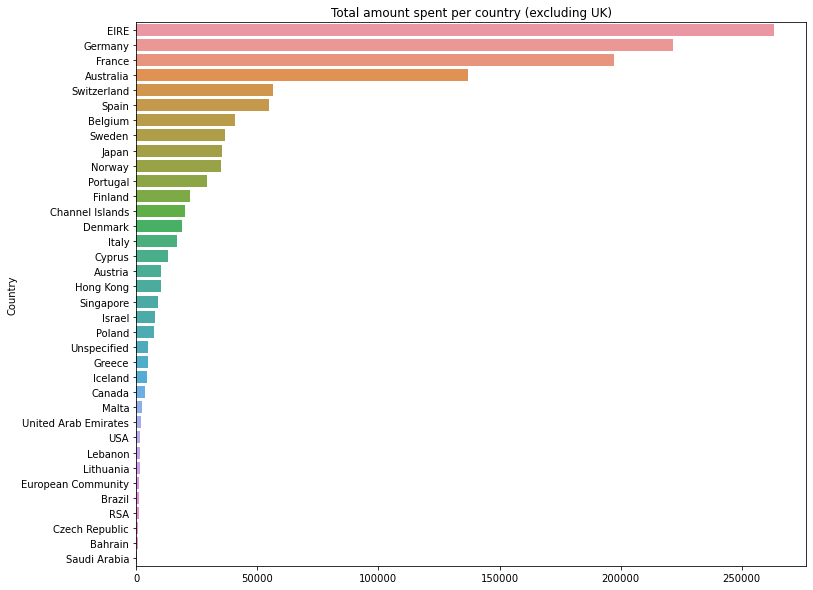

In [37]:
# Total amount spent per country (excluding UK)

plt.rcParams['figure.figsize']=(12,10)
a = data.groupby('Country').sum()['TotalSpent'].sort_values(ascending = False).tail(36)
# a = data['Country'].value_counts().tail(36)
sn.barplot(x = a.values, y=a.index).set_title('Total amount spent per country (excluding UK)')
plt.show()

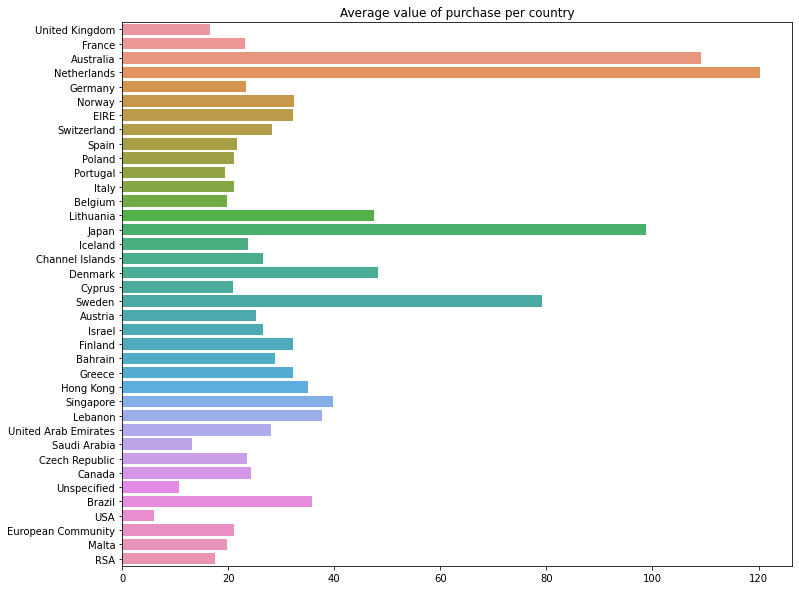

In [38]:
# To find the best spender country, we divide the total amount spent with the total number of purchases per country (although
# one should be careful here not to draw any conclusion, especially for the countries with small number of purchases)
                                                                                                                   
# plt.rcParams['figure.figsize']=(12,10)
# a = (data['Country'].sum()['TotalSpent']/data['Country'].value_counts())
# sn.barplot(x = a.values, y=a.index).set_title('Number of purchases per country (excluding UK)')
# plt.show()

countries_list = data['Country'].unique()
total_spent = []
total_purch = []
total_avg = []
for cntr in countries_list:
    total_spent.append(data[data['Country']==cntr]['TotalSpent'].sum())
    total_purch.append(data[data['Country']==cntr]['TotalSpent'].count())
    total_avg.append(data[data['Country']==cntr]['TotalSpent'].sum()/data[data['Country']==cntr]['TotalSpent'].count())
    
plt.rcParams['figure.figsize']=(12,10)
a = data['Country'].value_counts().tail(36)
sn.barplot(x = total_avg, y=countries_list).set_title('Average value of purchase per country')
plt.show()


We see here that Netherlands, Australia, Japan and Sweden are the top four. This could motivate starting special programs and 
offers in these countries. A further analysis would be required for the customers habits in these countries. 

### Monthly total spent and number of purchases per country

We will focus here only on countries with substantial number of purchases and total amount spent. Based on the plots 
we opt for UK, Netherlands, France, Germany and Eire.

In [54]:
countries = ['United Kingdom', 'Netherlands', 'France', 'Germany', 'EIRE']
country = {}
for cntr in countries:
    country[cntr]=data[data['Country'] == cntr].copy()
    country[cntr].drop('Country', axis = 1, inplace = True)

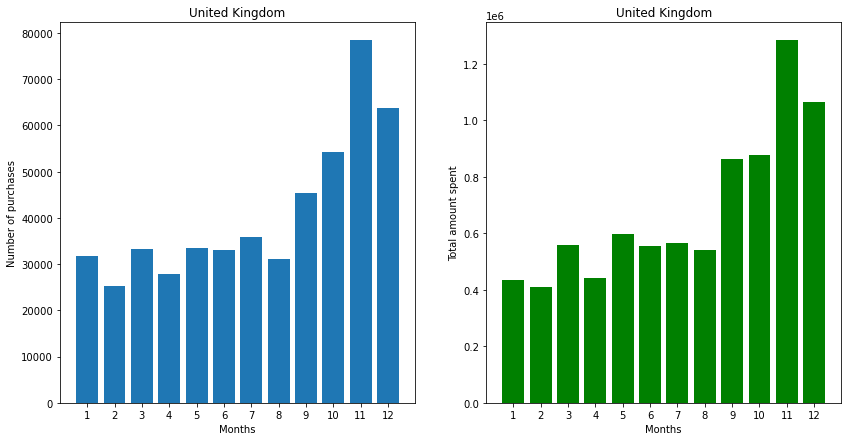

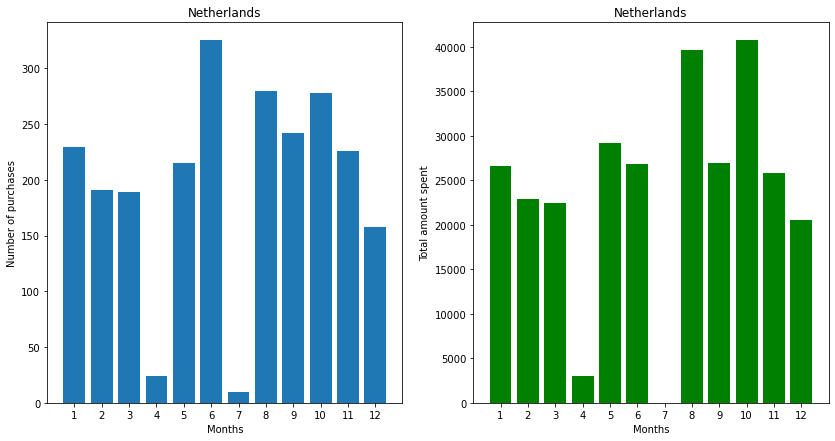

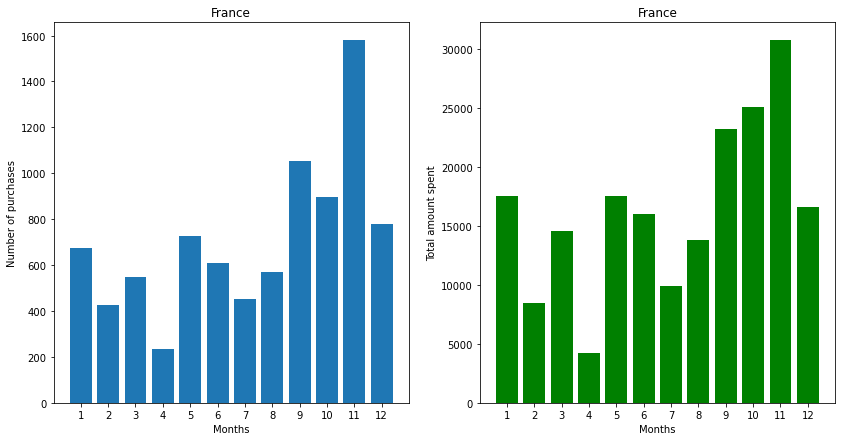

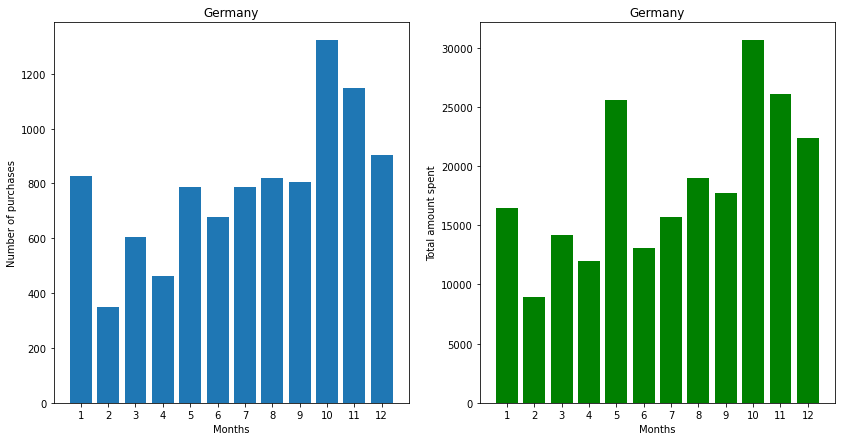

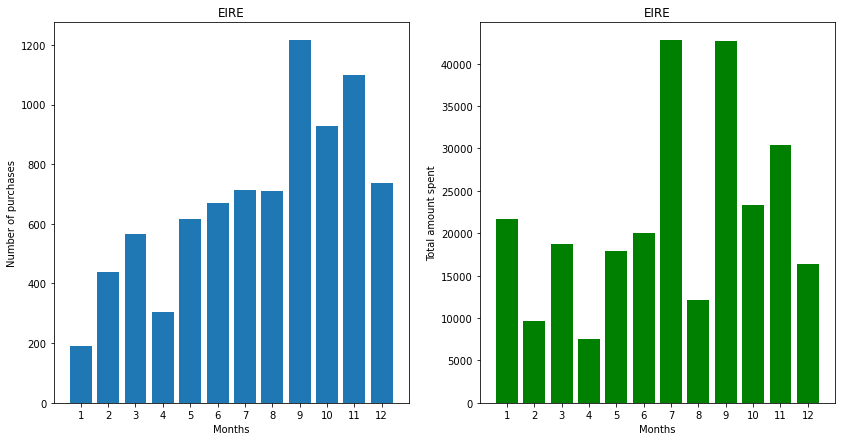

In [55]:
months = range(1,13)
for cntr in countries:
    df=country[cntr]
    plt.rcParams['figure.figsize']=(14,7)
    total = df.groupby('Month').count()['TotalSpent'].tolist()
    total2 = df.groupby('Month').sum()['TotalSpent'].tolist()
    plt.subplot(1, 2, 1)
    plt.bar(months, total)
    plt.xticks(months)
    plt.ylabel('Number of purchases')
    plt.xlabel('Months')
    plt.title(cntr)
    plt.subplot(1,2,2)
    plt.bar(months, total2, color='g')
    plt.xticks(months)
    plt.ylabel('Total amount spent')
    plt.xlabel('Months')
    plt.title(cntr)
    plt.show()

We note from the above that different countries may have different monthly shopping habits (which could partially be due to the fact that they have different holidays seasons).

### Hourly customer behavior

We next study the hourly activity of customers. This information could be useful, for example, for targeting 
advertisement.

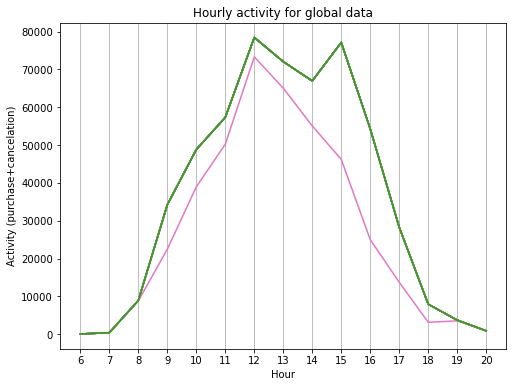

In [64]:
# Including all data
hours =[hour for hour, df in data.groupby('Hour')]

plt.rcParams['figure.figsize']=(8,6)
plt.plot(hours, data.groupby('Hour').count())
plt.xticks(hours)
plt.grid(axis = 'x')
plt.xlabel('Hour')
plt.ylabel('Activity (purchase+cancelation)')
plt.title('Hourly activity for global data')
plt.show()



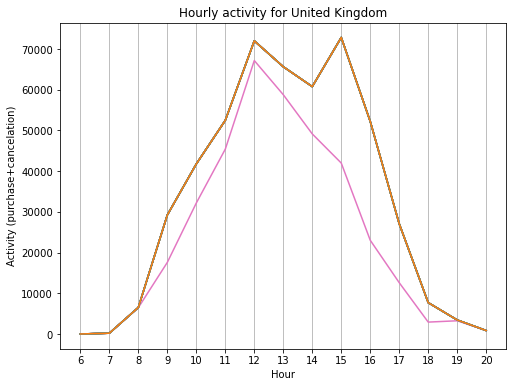

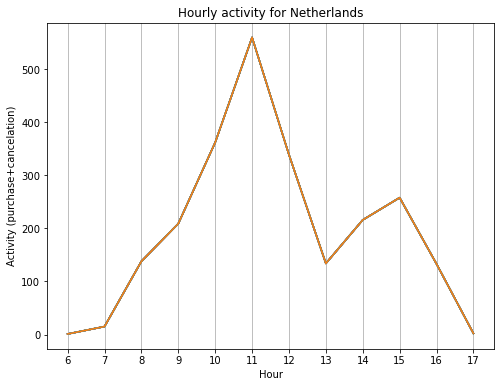

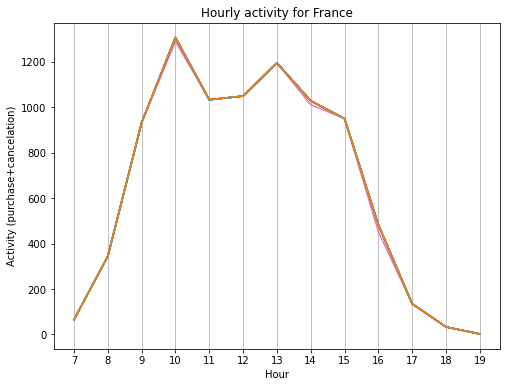

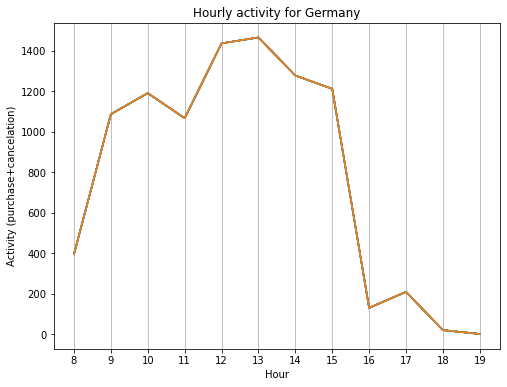

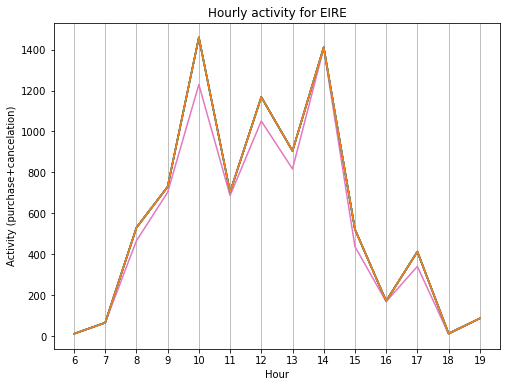

In [63]:
# For countries in country_list
for cntr in countries:
    plt.rcParams['figure.figsize']=(8,6)
    df = country[cntr]
    hours =[hour for hour, dfr in df.groupby('Hour')]
    plt.plot(hours, df.groupby('Hour').count())
    plt.xticks(hours)
    plt.xlabel('Hour')
    plt.ylabel('Activity (purchase+cancelation)')
    plt.grid(axis = 'x')
    plt.title('Hourly activity for {}'.format(cntr))
    plt.show()

## Local considerations

### Best buyers

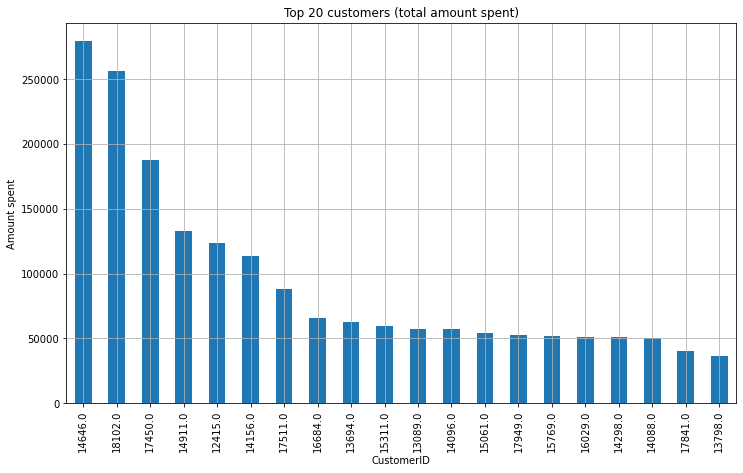

In [42]:
# Buyer who spent the most 

data['TotalSpent'].groupby(data['CustomerID']).sum().sort_values(ascending = False).head(20).plot.bar(figsize=(12,7))
plt.title('Top 20 customers (total amount spent)')
plt.ylabel('Amount spent')
plt.xlabel('CustomerID')
plt.grid()
plt.show()

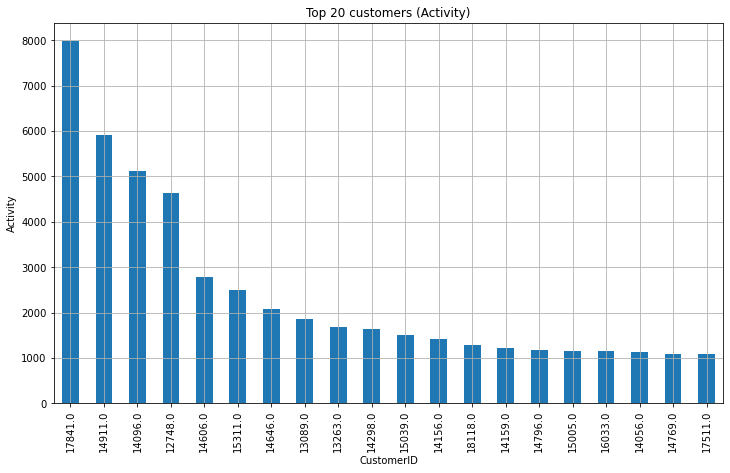

In [43]:
# Most active customer

data['TotalSpent'].groupby(data['CustomerID']).count().sort_values(ascending = False).head(20).plot.bar(figsize=(12,7))
plt.title('Top 20 customers (Activity)')
plt.ylabel('Activity')
plt.xlabel('CustomerID')
plt.grid()
plt.show()

### Most popular items

<ipython-input-58-4c4f59bf3a2e>:25: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(keys, rotation='vertical')
<ipython-input-58-4c4f59bf3a2e>:26: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


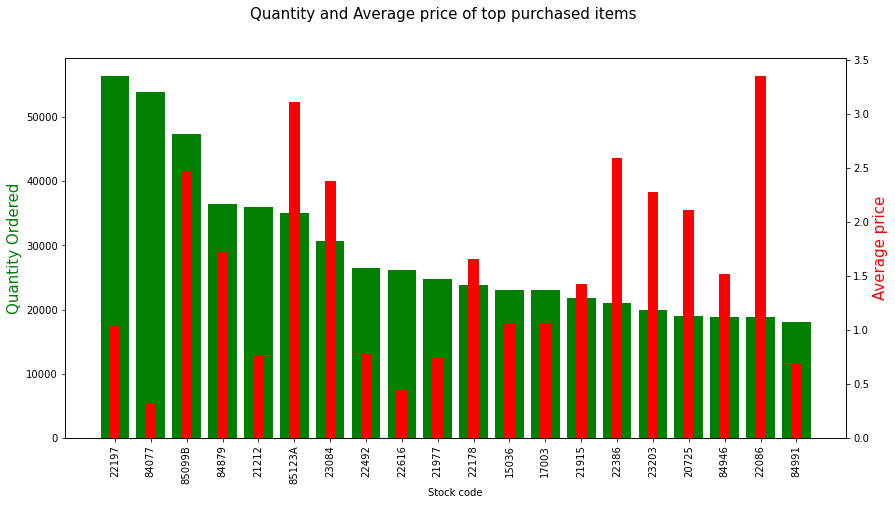

In [58]:
# data['Quantity'].groupby(data['StockCode']).sum().sort_values(ascending = False).head(20).plot.bar(figsize=(12,7))
# plt.title('Most popular items')
# plt.ylabel('Total quantity purchased')
# plt.grid()
# plt.show()
ndata=data.copy()
ndata['StockCode'] = ndata['StockCode'].astype(str)

keys = ndata['Quantity'].groupby(ndata['StockCode']).sum().sort_values(ascending = False).head(20).keys().tolist()
values = ndata['Quantity'].groupby(ndata['StockCode']).sum().sort_values(ascending = False).head(20).values
means = ndata['UnitPrice'].groupby(ndata['StockCode']).mean().loc[keys].values
# means = new.loc[keys].values


fig, ax1 = plt.subplots(figsize=(14,7))

fig.suptitle('Quantity and Average price of top purchased items', fontsize = 15)
ax2 = ax1.twinx()
ax1.bar(keys, values, color='g')
ax2.bar(keys, means, width = 0.3, color='r')

ax1.set_xlabel('Stock code')
ax1.set_ylabel('Quantity Ordered', color='g', fontsize = 15)
ax2.set_ylabel('Average price', color='r', fontsize = 15)
ax1.set_xticklabels(keys, rotation='vertical')
fig.show()

### Tuples of items most commonly bought together

In [46]:
# Create a new dataframe with only columns of interest: InvoiceNo and StockCode:

df = data.groupby('InvoiceNo')['StockCode'].apply(set).reset_index() # For each InvoiceNo, we find the set of all items in it
df['StockCode'] = df['StockCode'].apply(list) # We turn the set into a list
df.head()


,InvoiceNo,StockCode
0,536365,"[22752, 21730, 85123A, 84406B, 71053, 84029G, ..."
1,536366,"[22632, 22633]"
2,536367,"[22310, 84969, 48187, 84879, 21777, 22745, 217..."
3,536368,"[22960, 22913, 22914, 22912]"
4,536369,[21756]


In [48]:
# Next we count the couples of items that are bought together:

count = Counter()

for row in df['StockCode']:
    count.update(Counter(combinations(row, 2)))

print('Most commonly bought couples of items: \n')
for key, value in count.most_common(20):
    print(key, value)

Most commonly bought couples of items: 

(22697, 22699) 751
(21931, '85099B') 679
(22411, '85099B') 635
(22697, 22698) 609
(22726, 22727) 586
(23203, '85099B') 579
(22698, 22699) 567
(20725, 20727) 544
(22629, 22630) 514
(23300, 23301) 512
('85099B', 22386) 510
(22382, 22383) 509
(21928, '85099B') 507
(20719, 20724) 504
(20725, 20726) 498
(22383, 20725) 497
(23203, 23209) 497
(20727, 20728) 491
(20725, 20728) 485
(23202, 23203) 483


### A simple recommendation system based on counter

In [49]:
# A simple recommendation system based on the the previous counter:
count_sorted = count.most_common(len(count))

def recommend(item):
    l = []
    for couple in count_sorted:
        if item in couple[0]:
            l.append(couple[0])
        if len(l)==3:
            break
    s = set()
    for i in l:
        for j in i:
            s.add(j)
    final = s.difference({item})
    print('Customers who bought item {}'.format(item), 'were also interested in items:', final)

In [59]:
recommend(22726)

Customers who bought item 22726 were also interested in items: {22728, 22730, 22727}


In [60]:
recommend('85099B')

Customers who bought item 85099B were also interested in items: {23203, 22411, 21931}


# Predicting cancelations